In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize

import numpy as np
import os, glob
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=1
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle
import argparse, subprocess
from importlib import reload
import cmasher as cmr
from copy import deepcopy


In [2]:
mode = 'nh'
iout = 1026
repo, rurmode, dp = mode2repo(mode)
snap = uri.RamsesSnapshot(repo, iout, mode=rurmode)
snaps = uri.TimeSeries(snap)
snaps.read_iout_avail()
nout = snaps.iout_avail['iout']
gals = uhmi.HaloMaker.load(snap, galaxy=True, double_precision=dp)
hals = uhmi.HaloMaker.load(snap, galaxy=False, double_precision=dp)

[Output 01026] Age (Gyr) : 11.624 / 13.741, z = 0.17149 (a = 0.8536)


In [3]:
LG = pklload("./database/00_LocalGroup_fix.pickle")
print(LG.keys())
print(LG[2].keys())

dict_keys([1, 2, 3, 4, 7, 8, 9, 10, 14, 17, 23, 24, 25, 26, 29, 35, 36, 37, 40, 46, 47, 52, 63, 64, 75, 84, 92, 107, 108, 121, 129, 207, 11])
dict_keys(['BGG', 'neighbor', 'sats', 'subs', 'real'])


In [4]:
mass_in_sub = pklload("./database/01_mass_in_sub.pickle")
mass_in_sub.dtype
mass_in_sub_rvir = pklload("./database/01_mass_in_sub_rvir.pickle")
mass_in_sub_rvir.dtype

dtype((numpy.record, [('host', '<i4'), ('sub', '<i4'), ('dink', '?'), ('mdm', '<f8'), ('mstar', '<f8'), ('mcold', '<f8'), ('mcell', '<f8')]))

In [5]:
dinks = mass_in_sub[mass_in_sub['dink']]
pairs = mass_in_sub[~mass_in_sub['dink']]
dinks_rvir = mass_in_sub_rvir[mass_in_sub_rvir['dink']]
pairs_rvir = mass_in_sub_rvir[~mass_in_sub_rvir['dink']]

In [6]:
path = "./database/photo/02_components"
if(not os.path.isdir(path)):
    os.makedirs(path)


# Number compare

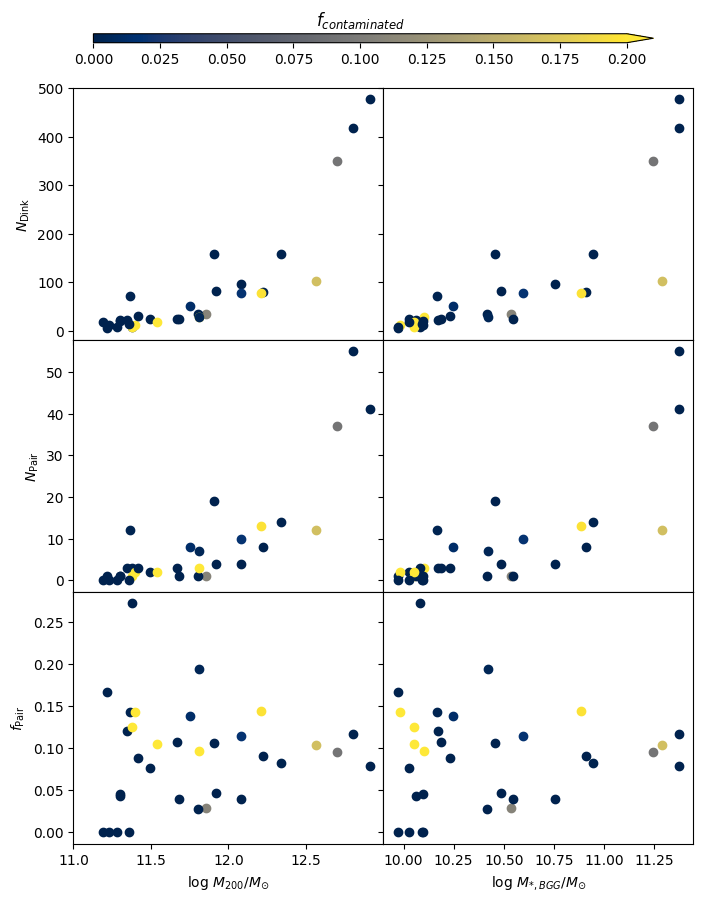

In [10]:
nrows=3; ncols=2
fig, axes = plt.subplots(nrows,ncols,figsize=(4*ncols,3*nrows), dpi=100, sharex='col', sharey='row')
cmap = colormaps['cividis']
# cmap = cmr.ember
norm = Normalize(0,0.2)
for key in LG.keys():
    BGG = LG[key]['BGG']
    color = cmap( norm(BGG['fcontam_200']) )
    idinks = np.sum(dinks['host'] == key)
    ipairs = np.sum(pairs['host'] == key)

    for i in range(2):
        name = 'm200' if(i==0) else 'm'
        axes[0,i].scatter(np.log10(BGG[name]), idinks, color=color)
        axes[1,i].scatter(np.log10(BGG[name]), ipairs, color=color)
        axes[2,i].scatter(np.log10(BGG[name]), ipairs/(ipairs+idinks), color=color)

        if(i==0):
            axes[0,i].set_ylabel(r"$N_{\rm Dink}$")
            axes[1,i].set_ylabel(r"$N_{\rm Pair}$")
            axes[2,i].set_ylabel(r"$f_{\rm Pair}$")
        axes[2,0].set_xlabel(r"log $M_{200}/M_{\odot}$")
        axes[2,1].set_xlabel(r"log $M_{*,BGG}/M_{\odot}$")
axes[2,0].set_xticks(axes[2,0].get_xticks()[:-2])

plt.subplots_adjust(hspace=0, wspace=0, top=0.95)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cax = fig.add_axes([0.15, 1, 0.7, 0.01])
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal', aspect=40, extend='max')
cbar.ax.set_title(r"$f_{contaminated}$")
plt.savefig(f"{path}/Numbers.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.show()
plt.close()

# Mass distribution

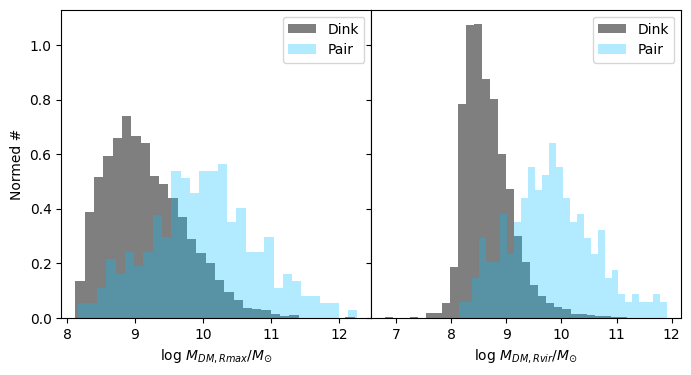

In [11]:
fig, axes = plt.subplots(1,2,figsize=(8,4), dpi=100, sharey=True)

ax = axes[0]
ax.hist( np.log10(dinks['mdm']), density=True, bins=30, label='Dink', ec='none',fc='k', alpha=0.5 )
ax.hist( np.log10(pairs['mdm']), density=True, bins=30, label='Pair',ec='none',fc='deepskyblue', alpha=0.3 )
ax.legend()
ax.set_ylabel("Normed #")
ax.set_xlabel(r"log $M_{DM,Rmax}/M_{\odot}$")

ax = axes[1]
ax.hist( np.log10(dinks_rvir['mdm']), density=True, bins=30, label='Dink', ec='none',fc='k', alpha=0.5 )
ax.hist( np.log10(pairs_rvir['mdm']), density=True, bins=30, label='Pair',ec='none',fc='deepskyblue', alpha=0.3 )
ax.set_xlabel(r"log $M_{DM,Rvir}/M_{\odot}$")
ax.legend()

plt.subplots_adjust(wspace=0)

plt.savefig(f"{path}/Mass_DM.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.show()
plt.close()

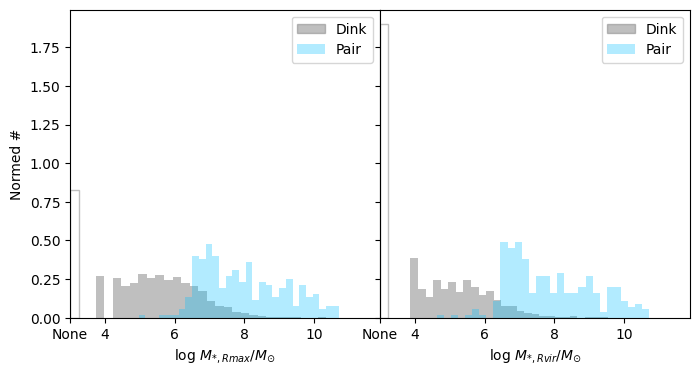

In [12]:
fig, axes = plt.subplots(1,2,figsize=(8,4), dpi=100, sharey=True)

ax = axes[0]
bar = ax.hist( np.log10(dinks['mstar']), density=True, bins=30, label='Dink', ec='none',fc='grey', alpha=0.5 )
bar[2].patches[0].set_facecolor('none')
bar[2].patches[0].set_edgecolor('grey')
ax.hist( np.log10(pairs['mstar']), density=True, bins=30, label='Pair',ec='none',fc='deepskyblue', alpha=0.3 )
leg = ax.legend()
leg.get_patches()[0].set_color('grey')
ax.set_ylabel("Normed #")
ax.set_xlabel(r"log $M_{*,Rmax}/M_{\odot}$")

xticks = np.append(ax.get_xticks(), 3)
ax.set_xticks(xticks)
xticklabels = ax.get_xticklabels()
xticklabels[-1] = 'None'
ax.set_xticklabels(xticklabels)
ax.set_xlim(3, 11.9)

ax = axes[1]
bar = ax.hist( np.log10(dinks_rvir['mstar']), density=True, bins=30, label='Dink', ec='none',fc='grey', alpha=0.5 )
bar[2].patches[0].set_facecolor('none')
bar[2].patches[0].set_edgecolor('grey')
ax.hist( np.log10(pairs_rvir['mstar']), density=True, bins=30, label='Pair',ec='none',fc='deepskyblue', alpha=0.3 )
ax.set_xlabel(r"log $M_{*,Rvir}/M_{\odot}$")
leg = ax.legend()
leg.get_patches()[0].set_color('grey')

xticks = np.append(ax.get_xticks(), 3)
ax.set_xticks(xticks)
xticklabels = ax.get_xticklabels()
xticklabels[-1] = 'None'
ax.set_xticklabels(xticklabels)
ax.set_xlim(3, 11.9)

plt.subplots_adjust(wspace=0)

plt.savefig(f"{path}/Mass_star.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.show()
plt.close()

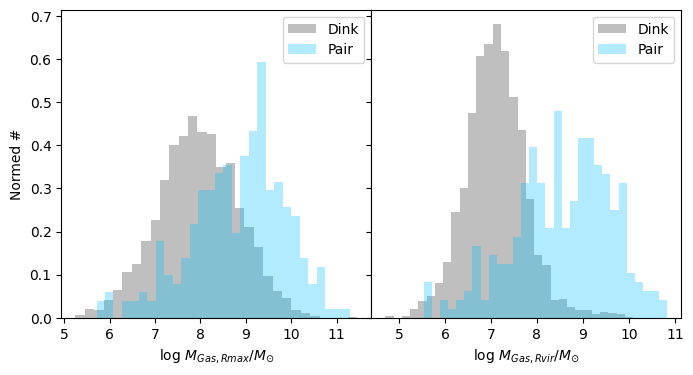

In [13]:
fig, axes = plt.subplots(1,2,figsize=(8,4), dpi=100, sharey=True)

ax = axes[0]
bar = ax.hist( np.log10(dinks['mcell']), density=True, bins=30, label='Dink', ec='none',fc='grey', alpha=0.5 )
# bar[2].patches[0].set_facecolor('none')
# bar[2].patches[0].set_edgecolor('grey')
ax.hist( np.log10(pairs['mcell']), density=True, bins=30, label='Pair',ec='none',fc='deepskyblue', alpha=0.3 )
leg = ax.legend()
# leg.get_patches()[0].set_color('grey')
ax.set_ylabel("Normed #")
ax.set_xlabel(r"log $M_{Gas,Rmax}/M_{\odot}$")

ax = axes[1]
bar = ax.hist( np.log10(dinks_rvir['mcell']), density=True, bins=30, label='Dink', ec='none',fc='grey', alpha=0.5 )
# bar[2].patches[0].set_facecolor('none')
# bar[2].patches[0].set_edgecolor('grey')
ax.hist( np.log10(pairs_rvir['mcell']), density=True, bins=30, label='Pair',ec='none',fc='deepskyblue', alpha=0.3 )
ax.set_xlabel(r"log $M_{Gas,Rvir}/M_{\odot}$")
leg = ax.legend()
# leg.get_patches()[0].set_color('grey')

plt.subplots_adjust(wspace=0)

plt.savefig(f"{path}/Mass_Gas.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.show()
plt.close()

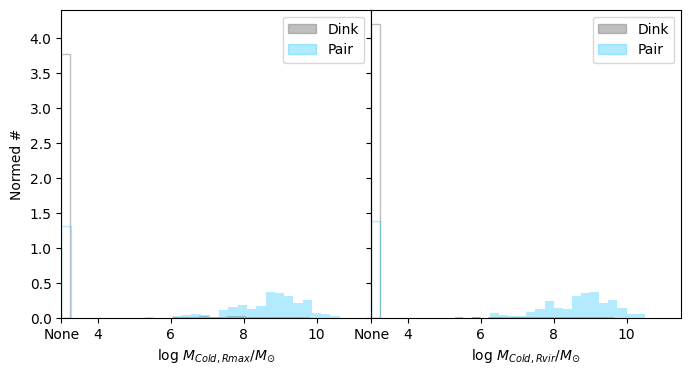

In [14]:
fig, axes = plt.subplots(1,2,figsize=(8,4), dpi=100, sharey=True)

ax = axes[0]
bar = ax.hist( np.log10(dinks['mcold']), density=True, bins=30, label='Dink', ec='none',fc='grey', alpha=0.5 )
bar[2].patches[0].set_facecolor('none')
bar[2].patches[0].set_edgecolor('grey')
bar = ax.hist( np.log10(pairs['mcold']), density=True, bins=30, label='Pair',ec='none',fc='deepskyblue', alpha=0.3 )
bar[2].patches[0].set_facecolor('none')
bar[2].patches[0].set_edgecolor('deepskyblue')
leg = ax.legend()
leg.get_patches()[0].set_color('grey')
leg.get_patches()[1].set_color('deepskyblue')
ax.set_ylabel("Normed #")
ax.set_xlabel(r"log $M_{Cold,Rmax}/M_{\odot}$")

xticks = np.append(ax.get_xticks(), 3)
ax.set_xticks(xticks)
xticklabels = ax.get_xticklabels()
xticklabels[-1] = 'None'
ax.set_xticklabels(xticklabels)
ax.set_xlim(3, 11.5)

ax = axes[1]
bar = ax.hist( np.log10(dinks_rvir['mcold']), density=True, bins=30, label='Dink', ec='none',fc='grey', alpha=0.5 )
bar[2].patches[0].set_facecolor('none')
bar[2].patches[0].set_edgecolor('grey')
bar = ax.hist( np.log10(pairs_rvir['mcold']), density=True, bins=30, label='Pair',ec='none',fc='deepskyblue', alpha=0.3 )
bar[2].patches[0].set_facecolor('none')
bar[2].patches[0].set_edgecolor('deepskyblue')
ax.set_xlabel(r"log $M_{Cold,Rvir}/M_{\odot}$")
leg = ax.legend()
leg.get_patches()[0].set_color('grey')
leg.get_patches()[1].set_color('deepskyblue')

xticks = np.append(ax.get_xticks(), 3)
ax.set_xticks(xticks)
xticklabels = ax.get_xticklabels()
xticklabels[-1] = 'None'
ax.set_xticklabels(xticklabels)
ax.set_xlim(3, 11.5)

plt.subplots_adjust(wspace=0)

plt.savefig(f"{path}/Mass_Cold.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.show()
plt.close()

# Mass Ratio

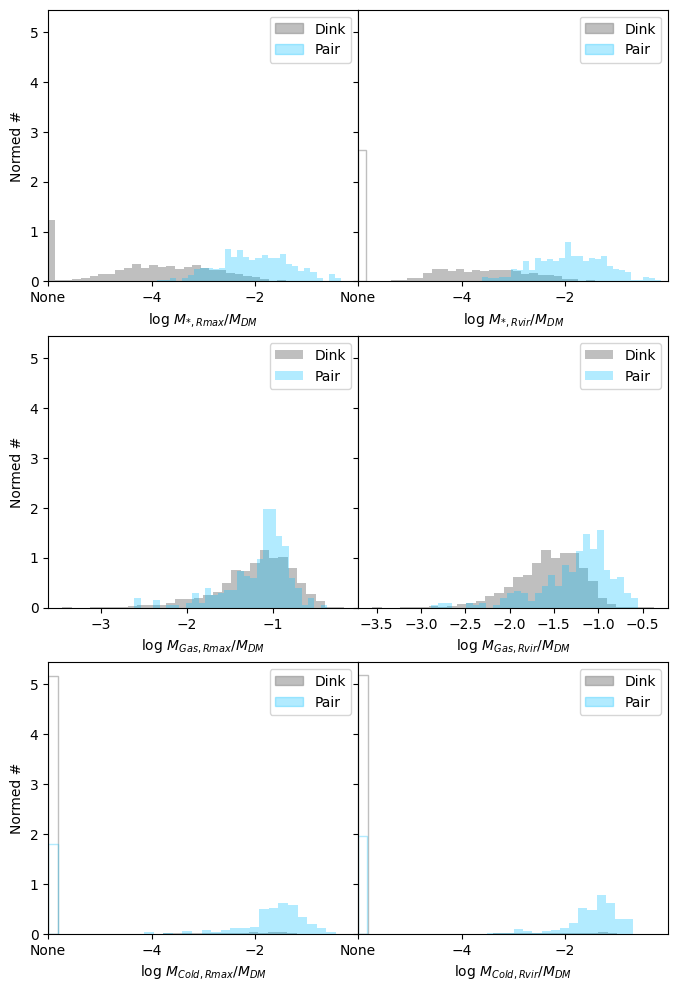

In [15]:
nrows = 3; ncols = 2
fig, axes = plt.subplots(nrows,ncols,figsize=(4*ncols,4*nrows), dpi=100, sharey=True)

names = ['mstar','mcell','mcold']
symbols = ['*','Gas','Cold']
radii = ['Rmax','Rvir']
for i in range(3):
    name = names[i]
    symbol = symbols[i]
    for j in range(2):
        radius = radii[j]
        ax = axes[i,j]
        if(j==0):
            dink_vals = dinks[name]/dinks['mdm']
            dink_vals[dinks[name] <= 1e3] = 1e-6
            pair_vals = pairs[name]/pairs['mdm']
            pair_vals[pairs[name] <= 1e3] = 1e-6
        else:
            dink_vals = dinks_rvir[name]/dinks_rvir['mdm']
            dink_vals[dinks_rvir[name] <= 1e3] = 1e-6
            pair_vals = pairs_rvir[name]/pairs_rvir['mdm']
            pair_vals[pairs_rvir[name] <= 1e3] = 1e-6
        bard = ax.hist( np.log10(dink_vals), density=True, bins=30, label='Dink', ec='none',fc='grey', alpha=0.5 )[2]
        changex = False
        if(bard.patches[0].get_x() <= -6):
            bard.patches[0].set_facecolor('none')
            bard.patches[0].set_edgecolor('grey')
            changex=True
        barp = ax.hist( np.log10(pair_vals), density=True, bins=30, label='Pair',ec='none',fc='deepskyblue', alpha=0.3 )[2]
        if(barp.patches[0].get_x() <= -6):
            barp.patches[0].set_facecolor('none')
            barp.patches[0].set_edgecolor('deepskyblue')
            changex=True
        if(changex):
            ax.set_xlim(ax.get_xlim())
            xticks = ax.get_xticks()
            if(not -6. in xticks):
                xticks = np.append(xticks, -6)
            ax.set_xticks(xticks)
            xticklabels = ax.get_xticklabels()
            xticklabels[np.where(xticks==-6)[0][0]] = 'None'
            ax.set_xticklabels(xticklabels)
            ax.set_xlim(-6, -0.01)
        ax.set_xlabel(fr"log $M_{{{symbol},{radius}}}/M_{{DM}}$")
        leg = ax.legend()
        if(changex):
            leg.get_patches()[0].set_color('grey')
            leg.get_patches()[1].set_color('deepskyblue')
        if(j==0): ax.set_ylabel("Normed #")
        
        

        # ax = axes[1]
        # bar = ax.hist( np.log10(dinks_rvir['mstar']), density=True, bins=30, label='Dink', ec='none',fc='grey', alpha=0.5 )
        # bar[2].patches[0].set_facecolor('none')
        # bar[2].patches[0].set_edgecolor('grey')
        # ax.hist( np.log10(pairs_rvir['mstar']), density=True, bins=30, label='Pair',ec='none',fc='deepskyblue', alpha=0.3 )
        # ax.set_xlabel(r"log $M_{*,Rvir}/M_{\odot}$")
        # leg = ax.legend()
        # leg.get_patches()[0].set_color('grey')

plt.subplots_adjust(wspace=0)

plt.savefig(f"{path}/Mass_ratios.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.show()
plt.close()